In [1]:
#!pip install pyairtable plotnine python-dotenv
import os
import pandas as pd

from dotenv import load_dotenv
from siuba import *
from plotnine import *

# NOTE: in order to access the transitdatabase, you must provide an API key.
# in order to do this, create a text file named _env and add an entry like this to it...
# AIRTABLE_API_KEY=<API_KEY>
load_dotenv("_env");

In [2]:
AIRTABLE_BASE="appPnJWrQ7ui4UmIl"

# Copied from https://github.com/cal-itp/data-infra/pull/518

from pyairtable import Table
from calitp import write_table, to_snakecase

def airtable_to_df(
    air_base_id,
    air_table_name,
    id_name="__id",
    rename_fields=None,
    column_prefix=None,
    api_key=None,
):
    """Download an airtable as a DataFrame.
    Note that airtable records have rows structured as follows:
        [{"id", "fields": {colname: value, ...}, ...]
    This function applies renames in the following order.
        1. rename id
        2. rename fields
        3. apply column prefix (to columns not renamed by 1 or 2)
    """

    api_key = os.environ["CALITP_AIRTABLE_API_KEY"] if not api_key else api_key

    if rename_fields:
        if not isinstance(rename_fields, dict):
            raise TypeError("rename fields must be a dictionary")
    else:
        rename_fields = {}

    all_rows = Table(api_key, air_base_id, air_table_name).all()
    raw_df = pd.DataFrame([{id_name: row["id"], **row["fields"]} for row in all_rows])

    # rename fields follows format new_name: old_name
    final_df = raw_df.rename(columns={v: k for k, v in rename_fields.items()}).pipe(
        to_snakecase
    )

    if column_prefix:
        return final_df.rename(
            columns=lambda s: s
            if (s in rename_fields or s == id_name)
            else f"{column_prefix}{s}"
        )

    return final_df

def read_transit(table_name, **kwargs):
    return airtable_to_df(AIRTABLE_BASE, table_name, api_key=os.environ["AIRTABLE_API_KEY"], **kwargs)

In [3]:
tbl_services = read_transit("services", rename_fields = {"provider_id": "Provider"})
tbl_organizations = read_transit("organizations", id_name = "organization_id")

tbl_service_realtime_status = (
    tbl_services
    >> pipe(_.explode("provider_id"))
    >> select(_.service_name == _.name, _.provider_id, _.realtime_status)
)

## Organization services and GTFS RT coverage

Note that for analyses below, only organizations with at least 1 service listed were used.

In [4]:
tbl_organization_service = (
    tbl_organizations
    >> select(_.organization_id, _.organization_name == _.name)
    >> left_join(
        _,
        tbl_service_realtime_status,
        {"organization_id": "provider_id"}
    )
)

In [5]:
tbl_org_service_counts = (
    tbl_organization_service
    >> group_by(_.organization_name)
    >> summarize(
        n_services = _.service_name.notna().sum(),
        n_gtfs_rt_service = (_.realtime_status == "Complete").sum()
    )
    >> filter(_.n_services > 0)
    >> mutate(
        prop_rt_service = _.n_gtfs_rt_service / _.n_services
    )
)

### How many services do organizations have?

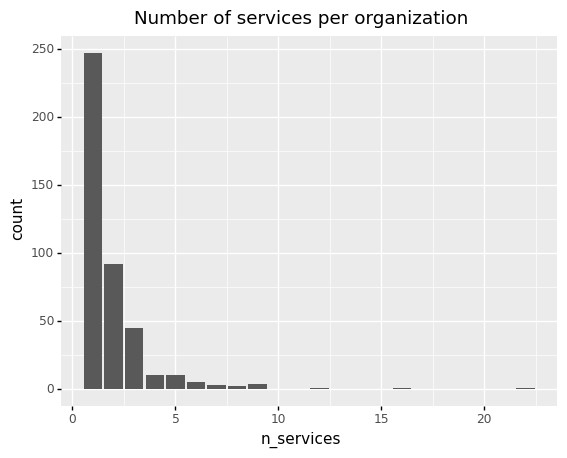

<ggplot: (8761293210094)>

In [6]:
tbl_org_service_counts >> ggplot(aes("n_services")) + geom_bar() + labs(title = "Number of services per organization")

### Proportion of services with GTFS RT coverage per organization

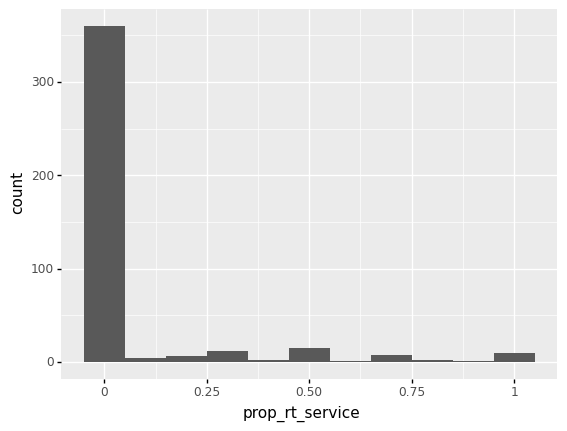

<ggplot: (8761293173794)>

In [7]:
tbl_org_service_counts >> ggplot(aes("prop_rt_service")) + geom_histogram(binwidth=.1)

### Proportion of organizations with any complete GTFS RT feed

A feed is complete if it has the following:

* vehicle positions
* trip updates
* service alerts

In [13]:
(
    tbl_org_service_counts
    >> group_by(_.organization_name)
    >> summarize(any_rt_service = _.n_gtfs_rt_service > 0)
    >> count(_.any_rt_service)
#    >> ggplot(aes("any_rt_service")) + geom_bar()
)

,any_rt_service,n
0,False,360
1,True,61


## Services

### How many services are covered by a complete GTFS RT feed?

In [9]:
tbl_services >> count(_.realtime_status)

,realtime_status,n
0,Complete,94
1,Incomplete,713


### How many services are not associated with a providing organization?

In [10]:
tbl_service_realtime_status >> count(no_provider = _.provider_id.isna())

,no_provider,n
0,False,809
1,True,6


## GTFS RT feeds in warehouse

In [11]:
import calitp.magics

In [12]:
%%sql -o tbl_agencies_rt_feed_counts --quiet

WITH dated AS (
    SELECT
        *,
    
        gtfs_rt_vehicle_positions_url IS NOT NULL AND gtfs_rt_service_alerts_url IS NOT NULL AND gtfs_rt_trip_updates_url IS NOT NULL
          AS has_all_gtfs_rt_urls,
    
        REGEXP_EXTRACT(_FILE_NAME, ".*/([0-9]+-[0-9]+-[0-9]+)") AS day

    FROM gtfs_schedule_history.calitp_feeds_raw
)

SELECT day, has_all_gtfs_rt_urls, COUNT(*) AS n
FROM dated
GROUP BY 1, 2


KeyboardInterrupt: 

In [ ]:
tbl_agencies_rt_feed_counts >> filter(_.day == _.day.max())